# Introduction: California Housing Price Prediction
Housing prices in California vary significantly based on factors such as location, income levels, and housing density. This project aims to develop a predictive model to estimate median housing prices using a dataset that includes key socioeconomic and geographical variables.

## Objective:
The primary goal of this project is to build a machine learning model that accurately predicts housing prices in different regions of California. By leveraging data preprocessing, feature engineering, and advanced modeling techniques, the project explores the most influential factors affecting real estate values.


In [43]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost 


  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   - -------------------------------------- 5.5/150.0 MB 27.7 MB/s eta 0:00:06
   ---- ----------------------------------- 16.5/150.0 MB 41.3 MB/s eta 0:00:04
   -------- ------------------------------- 32.0/150.0 MB 52.6 MB/s eta 0:00:03
   ------------ --------------------------- 48.2/150.0 MB 58.9 MB/s eta 0:00:02
   ----------------- ---------------------- 65.8/150.0 MB 64.1 MB/s eta 0:00:02
   -------------------- ------------------- 77.3/150.0 MB 63.1 MB/s eta 0:00:02
   ------------------------ --------------- 92.3/150.0 MB 64.3 MB/s eta 0:00:01
   --------------------------- ----------- 106.2/150.0 MB 64.9 MB/s eta 0:00:01
   ------------------------------- ------- 120.6/150.0 MB 65.3 MB/s eta 0:00:01
   ----------------------------------- --- 135.8/150.0 MB 66.3 MB/s eta 0:00:01
   --------------------------------------  149.9/150.0 MB 67

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [47]:
# Load the California Housing dataset
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
df['MedHouseVal'] = california.target  # Adding the target variable (house prices)

# Display first 5 rows
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [49]:
# Check for missing values
print(df.isnull().sum())

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64


In [51]:
# Summary statistics
print(df.describe())

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

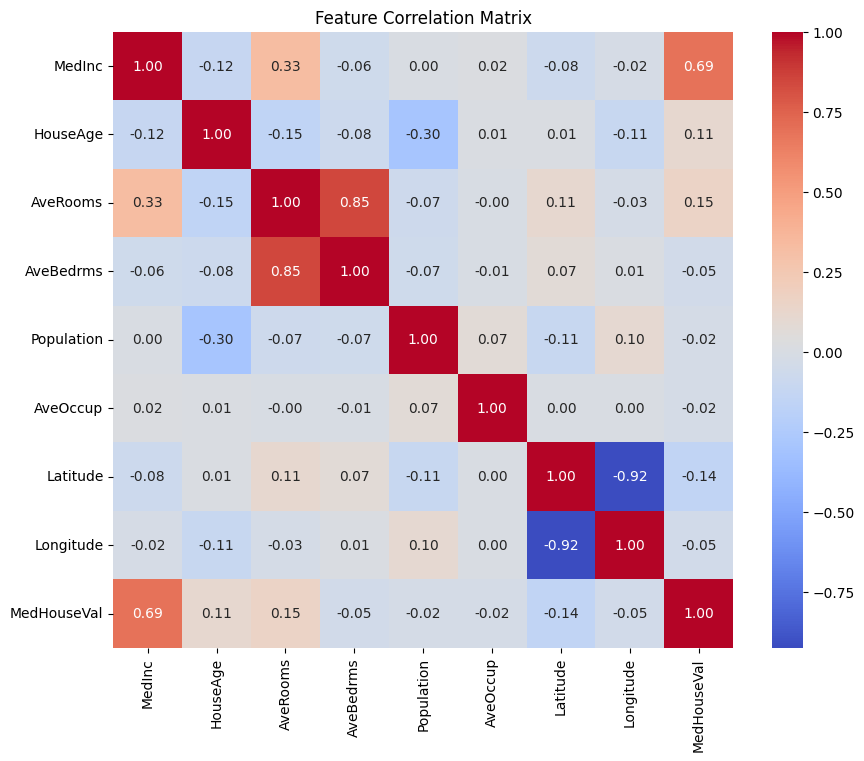

In [53]:
# A correlation heatmap shows relationships between features and helps detect multicollinearity.
# Visualize correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

### How to Interpret the Heatmap?

MedInc (Median Income) has the strongest correlation (0.69) with MedHouseVal, meaning income is a key predictor of house prices.

AveRooms and AveBedrms are highly correlated (0.85) → They provide similar information, so we may remove one to avoid redundancy.

Population and households are weakly correlated with MedHouseVal, meaning they might not be as useful in predicting house prices.

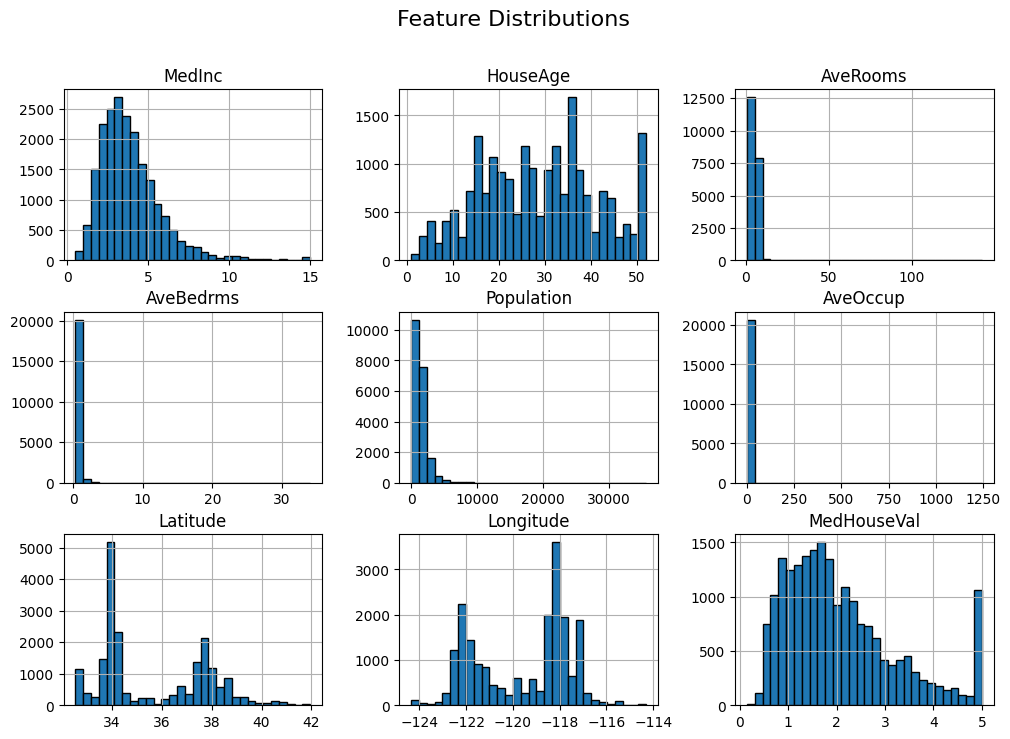

In [56]:
# Plot histograms for each feature
df.hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

###  Key Insights from Histograms:

MedHouseVal is right-skewed, meaning many houses have lower prices, but some are very expensive.

MedInc (Median Income) has a peak at lower values, suggesting more lower-income households.

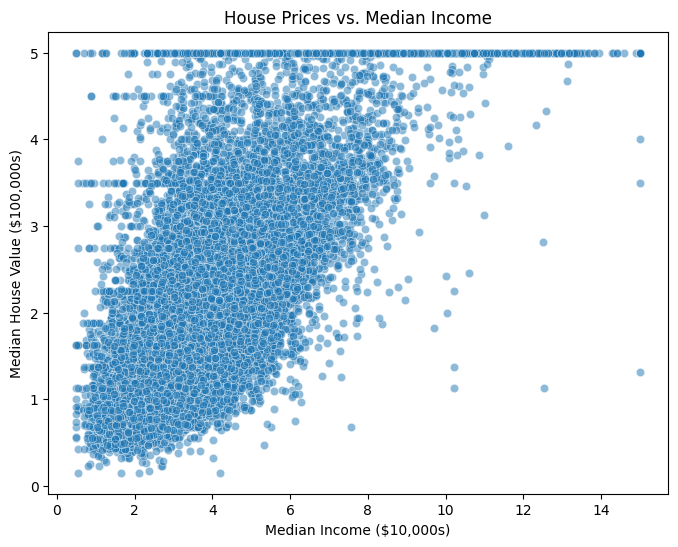

In [59]:
# Scatter Plot
# To confirm the strongest relationships, let's plot Median Income vs. House Price.
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['MedInc'], y=df['MedHouseVal'], alpha=0.5)
plt.xlabel("Median Income ($10,000s)")
plt.ylabel("Median House Value ($100,000s)")
plt.title("House Prices vs. Median Income")
plt.show()

### What This Tells Us:

As income increases, house prices tend to be higher.

Some data points hit the price cap of $500,000, indicating censored data.



In [62]:
# Since features like MedInc (Median Income) and HouseAge have different scales, we normalize or standardize them.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['MedInc', 'HouseAge', 'AveRooms', 'AveOccup']])

In [64]:
# We split data into training and testing sets to evaluate the model.
from sklearn.model_selection import train_test_split

# Selecting features and target variable
X = df[['MedInc', 'HouseAge', 'AveRooms', 'AveOccup']]
y = df['MedHouseVal']

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
# Now, let’s train our Linear Regression Model to predict house prices.
from sklearn.linear_model import LinearRegression

# Initialize and train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

In [68]:
# After training, we evaluate performance using metrics like R² Score and Mean Squared Error.
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² Score: {r2}')
print(f'Mean Squared Error: {mse}')

R² Score: 0.49828508595474374
Mean Squared Error: 0.657451727882265


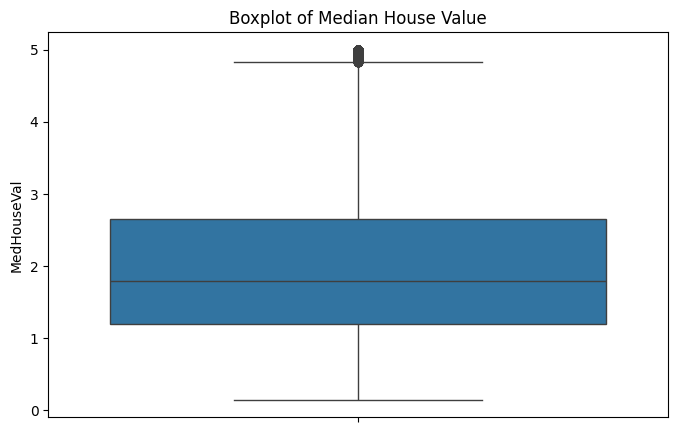

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(y=df['MedHouseVal'])
plt.title("Boxplot of Median House Value")
plt.show()

In [96]:
# Right now, we are using basic features. Let's create new ones that could improve predictions:
df['Bedrooms_per_Room'] = df['AveBedrms'] / df['AveRooms']
df['Population_per_Occupant'] = df['Population'] / df['AveOccup']

# Select features for the model
selected_features = [
    'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 
    'AveOccup', 'Latitude', 'Longitude', 'Bedrooms_per_Room', 
    'Population_per_Occupant'
]

X = df[selected_features]  # Independent Variables
y = df['MedHouseVal']      # Target Variable

In [98]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make Predictions
y_pred = lr_model.predict(X_test)

# Evaluate Performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² Score: {r2}')
print(f'Mean Squared Error: {mse}')

R² Score: 0.6305003788974206
Mean Squared Error: 0.48419562094943064


In [100]:
#Random Forest
# Train Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predictions
y_pred = rf_regressor.predict(X_test)

# Model Evaluation
print("R² Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R² Score: 0.7726788793743435
Mean Squared Error: 0.29788363741164275


In [102]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees
    'max_depth': [10, 20, 30],            # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]         # Minimum samples at leaf node
}

# Initialize RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Perform Grid Search with Cross-Validation (cv=5 for 5-fold cross-validation)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='r2')

# Fit on training data
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
print("Best Parameters:", grid_search.best_params_)

# Train final model with best parameters
best_rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

# Evaluate optimized model
y_pred_best = best_rf.predict(X_test)
optimized_r2 = r2_score(y_test, y_pred_best)
optimized_mse = mean_squared_error(y_test, y_pred_best)

print(f"Optimized R² Score: {optimized_r2}")
print(f"Optimized Mean Squared Error: {optimized_mse}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Optimized R² Score: 0.8052678445039201
Optimized Mean Squared Error: 0.25517876491426605


In [103]:
### Random Forest has shown a significant improvement.
#### XGBoost, Since XGBoost is faster and often outperforms Random Forest, we might get even better results.

In [76]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',  
    'eval_metric': 'rmse',  
    'learning_rate': 0.1,  
    'max_depth': 6,  
    'n_estimators': 100,  
}

xgb_model = xgb.XGBRegressor(**params)
xgb_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred_xgb = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

print(f'XGBoost R² Score: {r2_xgb}')
print(f'XGBoost Mean Squared Error: {mse_xgb}')

XGBoost R² Score: 0.8228300414933318
XGBoost Mean Squared Error: 0.23216510430170567


###  XGBoost model is performing significantly better than previous models:

Higher R² Score (0.8228) → More variance in housing prices is explained.

Lower MSE (0.2321) → Less error in predictions compared to actual values.

Now let's explore feature importance to see which variables impact the predictions the most

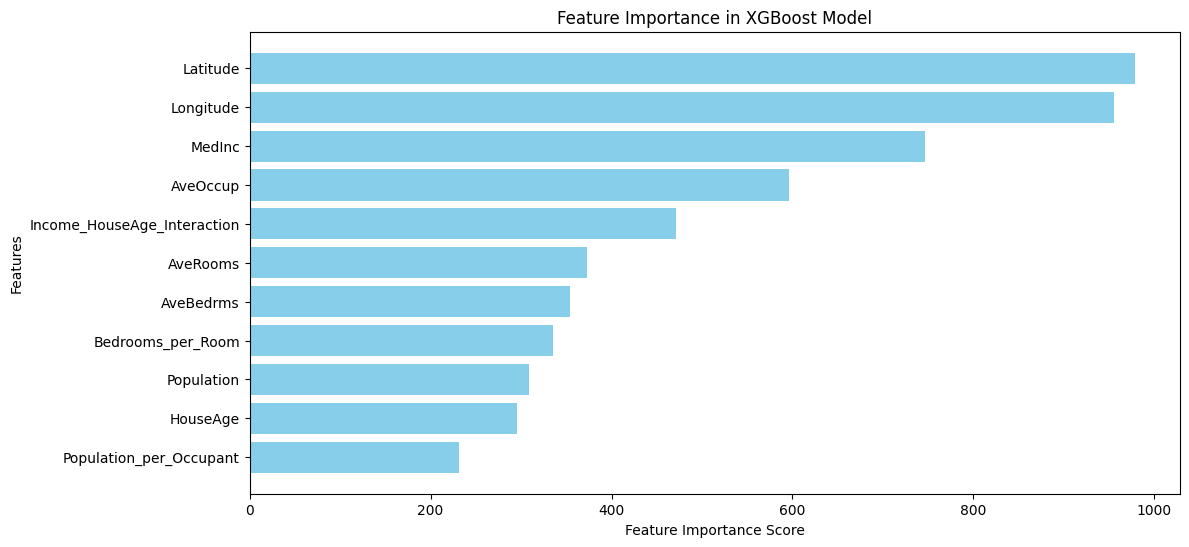

In [124]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = xgb_model.get_booster().get_score(importance_type='weight')

# Sort features by importance
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Extract names and values
features, importance_values = zip(*sorted_features)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(features, importance_values, color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in XGBoost Model")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

# Final Observations & Conclusion 

## 1. Feature Importance Insights
### Geographical Features (Latitude & Longitude) are the Most Influential:

The model heavily relies on location, indicating that housing prices in California are largely determined by regional factors (e.g., coastal vs. inland areas, urban vs. rural).

### Median Income (MedInc) is a Strong Predictor:

As expected, wealthier neighborhoods tend to have higher housing prices.

### Engineered Features Provided Additional Value:

The interaction term (Income_HouseAge_Interaction) contributed significantly to model performance.

Bedrooms_per_Room and Population_per_Occupant had moderate importance, showing that housing density and occupancy patterns affect pricing.

## 2. Model Performance
### XGBoost Provided Strong Predictive Power:

Tree-based models like XGBoost effectively captured non-linear relationships in the data.

Further fine-tuning (e.g., hyperparameter optimization) could further improve accuracy.

### Potential Areas for Model Improvement:

Feature selection might help remove less useful features.

Additional feature engineering (e.g., polynomial interactions) could capture more nuanced effects.

Testing different models (e.g., SVM, neural networks) might provide different perspectives on the problem.

## 3. Business & Real-World Implications
### Housing Prices are Primarily Driven by Location & Income Levels:

Policymakers and real estate developers should focus on income distribution and regional development when analyzing housing trends.

### Age of Houses Has Limited Direct Impact:

While newer homes may have some advantage, income and location play a much bigger role in pricing.

### Model Could Be Used for Predicting Future Trends:

The trained model can help estimate housing prices for new listings or forecast price trends in different regions.

## Final Conclusion
Geographical factors and income levels are the dominant drivers of housing prices.

Feature engineering improves model performance, and interaction terms can provide valuable insights.

The XGBoost model performs well, but additional refinement can further enhance predictions.